# ReGraph tutorial: from simple graph rewriting to a graph hierarchy

This notebook consists of simple examples of usage of the ReGraph library

In [29]:
import copy

import networkx as nx

from regraph.library.hierarchy import Hierarchy
from regraph.library.rules import Rule
from regraph.library.plotting import plot_graph, plot_instance, plot_rule
from regraph.library.primitives import find_matching, rewrite, print_graph
from regraph.library.utils import keys_by_value

import matplotlib.pyplot as plt

## I. Simple graph rewriting

### 1. Initialization of a graph

ReGraph works with NetworkX graph objects, both undirected graphs (`nx.Graph`) and directed ones (`nx.DiGraph`). The workflow of the graph initialization in NetworkX can be found [here](http://networkx.readthedocs.io/en/networkx-1.11/tutorial/tutorial.html).

In [30]:
graph = nx.DiGraph()
graph.add_nodes_from([
    ('1', {'name': 'EGFR', 'state': 'p'}),
    ('2', {'name': 'BND'}),
    ('3', {'name': 'Grb2', 'aa': 'S', 'loc': 90}),
    ('4', {'name': 'SH2'}),
    ('5', {'name': 'EGFR'}),
    ('6', {'name': 'BND'}),
    ('7', {'name': 'Grb2'}),
    ('8', {'name': 'WAF1'}),
    ('9', {'name': 'BND'}),
    ('10', {'name': 'G1-S/CDK', 'state': 'p'}),
])
edges = [
    ('1', '2', {'s': 'p'}),
    ('4', '2', {'s': 'u'}),
    ('4', '3'),
    ('5', '6', {'s': 'p'}),
    ('7', '6', {'s': 'u'}),
    ('8', '9'),
    ('9', '8'),
    ('10', '8', {"a": {1}}),
    ('10', '9', {"a": {2}}),
    ('5', '2', {'s': 'u'})
]

graph.add_edges_from(edges)

ReGraph provides some utils for graph plotting that are going to be used in the course of this tutorial.

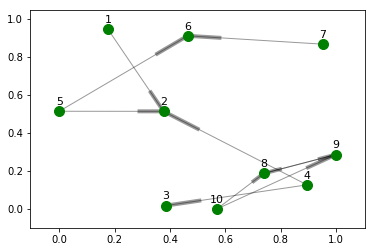

In [31]:
positioning = plot_graph(graph)

### 2. Initialization of a rule

- Graph rewriting is implemented as an application of a **graph rewriting rule** to a given input graph object $G$. A graph rewriting rule $R$  is a span $LHS \leftarrow P \rightarrow RHS$, where $LHS$ is a graph that represents a left hand side of the rule -- a pattern that is going to be matched inside of the graph, $P$ is a graph that represents a preserved part of the rule -- together with a homomorphism $LHS \leftarrow P$ it specifies nodes and edges that are going to be preserved in the course of application of the rule. $RHS$ and a homomorphism $P \rightarrow RHS$ on the other hand specify nodes and edges that are going to be added. In addition, if two nodes $n^P_1, n^P_2$ of $P$ map to the same node $n^{LHS}$ in $LHS$, $n^{LHS}$ is going to be cloned during graph rewriting. Symmetrically, if two nodes of $n^P_1$ and $n^P_2$ in $P$ match to the same node $n^{RHS}$ in $RHS$, $n^P_1$ and $n^P_2$ are merged.

- $LHS$, $P$ and $RHS$ can be defined as NetworkX graphs

In [32]:
pattern = nx.DiGraph()
pattern.add_nodes_from(
    [(1, {'state': 'p'}),
     (2, {'name': 'BND'}),
     3,
     4]
)
pattern.add_edges_from(
    [(1, 2, {'s': 'p'}),
     (3, 2, {'s': 'u'}),
     (3, 4)]
)

p = nx.DiGraph()
p.add_nodes_from([
    (1, {'state': 'p'}),
    '1_clone',
    (2, {'name': 'BND'}),
    3,
    4
])
p.add_edges_from([
    (1, 2),
    ('1_clone', 2),
    (3, 4)
])

rhs = nx.DiGraph()
rhs.add_nodes_from([
    (1, {'state': 'p'}),
    '1_clone',
    (2, {'name': 'BND'}),
    3,
    4,
    5
])

rhs.add_edges_from([
    (1, 2, {'s': 'u'}),
    ('1_clone', 2),
    (2, 4),
    (3, 4),
    (5, 3)
])

p_lhs = {1: 1, '1_clone': 1, 2: 2, 3: 3, 4: 4}
p_rhs = {1: 1, '1_clone': '1_clone', 2: 2, 3: 3, 4: 4}

- A rule of graph rewriting is implemeted in the class `regraph.library.rules.Rule`. An instance of `regraph.library.rules.Rule` is initialized with NetworkX graphs $LHS$, $P$, $RHS$, and two dictionaries specifying $LHS \leftarrow P$ and $P \rightarrow RHS$.
- For visualization of a rule `regraph.library.plotting.plot_rule` util is implemented in ReGraph.

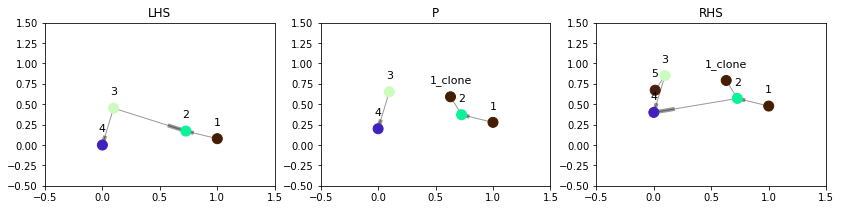

In [33]:
rule = Rule(p, pattern, rhs, p_lhs, p_rhs)
plot_rule(rule)

### 1. Rewriting

#### 1.1. Matching of LHS

- The matchings of $LHS$ in $G$ ($LHS \rightarrowtail G$) can be found using `regraph.library.primitives.find_matching` function. This function returns a list of dictionaries representing the matchings. If no matchings were found the list is empty.
- Visualization of the matching in $G$ is implemented in the `regraph.library.plotting.plot_instance` util.

Instances:
{1: '1', 2: '2', 3: '5', 4: '6'}


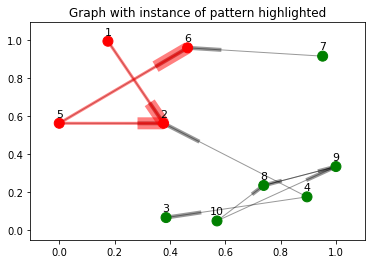

{1: '1', 2: '2', 3: '4', 4: '3'}


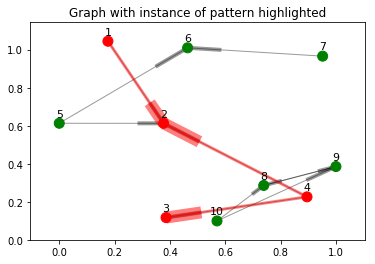

In [34]:
instances = find_matching(graph, rule.lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(graph, rule.lhs, instance, pos=positioning)

#### 1.2. Rewriting

Graph rewriting is performed with the `regraph.library.primitives.rewrite` function. It takes as an input a graph, an instance of the matching (dictionary that specifies the mapping from the nodes of $LHS$ to the nodes of $G$) and a rewriting rule (an instance of the `regraph.library.rules.Rule` class).

In [35]:
rewrite(graph, instances[0], rule)

{1: '1', 2: '2', 3: '5', 4: '6', 5: 5, '1_clone': '11'}

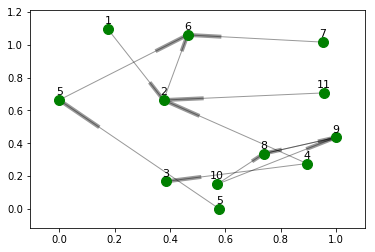

In [36]:
new_pos = plot_graph(graph, parent_pos=positioning)

## II. Hierarchy of graphs & rewriting

ReGraph allows to create a herarchy of graphs connected together by means of **typing homomorphisms**. In the context of hierarchy if there exist a homomorphism $G \rightarrow T$ we say that graph $G$ is typed by a graph $T$. Graph hierarchy is a DAG, where nodes are graphs and edges are typing homomorphisms between graphs.

### 1. Example: simple hierarchy 

#### 1.1. Initialization of a hierarchy
Consider the following example of a simple graph hierarchy. The two graphs $G$ and $T$ are being created and added to the heirarchy. Afterwards a typing homomorphism between $G$ and $T$ is added, so that every node of $G$ is typed by some node in $T$.

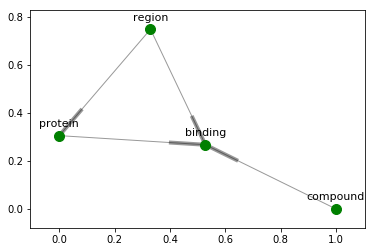

{'binding': array([ 0.52835831,  0.3175462 ]),
 'compound': array([ 1.  ,  0.05]),
 'protein': array([ 0.      ,  0.355668]),
 'region': array([ 0.32974005,  0.79932786])}

In [37]:
g = nx.DiGraph()
g.add_nodes_from(["protein", "binding", "region", "compound"])
g.add_edges_from([("region", "protein"), ("protein", "binding"), ("region", "binding"), ("compound", "binding")])
plot_graph(g)

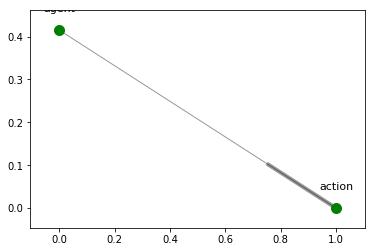

{'action': array([ 1.  ,  0.05]), 'agent': array([ 0.        ,  0.46526715])}

In [38]:
t = nx.DiGraph()
t.add_nodes_from(["action", "agent"])
t.add_edges_from([("agent", "agent"), ("agent", "action")])
plot_graph(t)

In [39]:
simple_hierarchy = Hierarchy()
simple_hierarchy.add_graph("G", g, {"name": "Simple protein interaction"})
simple_hierarchy.add_graph("T", t, {"name": "Agent interation"})
simple_hierarchy.add_typing(
    "G", "T",
    {"protein": "agent",
     "region": "agent",
     "compound": "agent",
     "binding": "action",
    }
)

In [40]:
print(simple_hierarchy)


Graphs (directed == True): 

Nodes:
Graph: G {'name': 'Simple protein interaction'}
Graph: T {'name': 'Agent interation'}

Typing homomorphisms: 
G -> T: ignore_attrs == False

attributes : 
{}



We can now add new level to the hierarchy and type in by $G$.

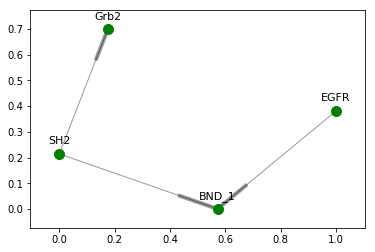

In [41]:
g_prime = nx.DiGraph()
g_prime.add_nodes_from(
    ["EGFR", "BND_1", "SH2", "Grb2"]
)
g_prime.add_edges_from([
    ("EGFR", "BND_1"),
    ("SH2", "BND_1"),
    ("SH2", "Grb2")
])
simple_hierarchy.add_graph("G_prime", g_prime, {"name": "EGFR and Grb2 binding"})
simple_hierarchy.add_typing(
    "G_prime", "G",
    {
        "EGFR": "protein",
        "BND_1": "binding",
        "SH2": "region",
        "Grb2": "protein"
    }
)
pos = plot_graph(g_prime)

In [42]:
print(simple_hierarchy)


Graphs (directed == True): 

Nodes:
Graph: G {'name': 'Simple protein interaction'}
Graph: G_prime {'name': 'EGFR and Grb2 binding'}
Graph: T {'name': 'Agent interation'}

Typing homomorphisms: 
G -> T: ignore_attrs == False
G_prime -> G: ignore_attrs == False

attributes : 
{}



#### 1.2. Rewriting in the hierarchy

ReGraph implements rewriting of graphs in the hierarchy, this rewriting is more restrictive as application of a rewriting rule cannot violate any typing defined in the hierarchy. The following code illustrates the application of a rewriting rule to the graph in the hierarchy. On the first step we create a `Rule` object containing a rule we would like to apply.

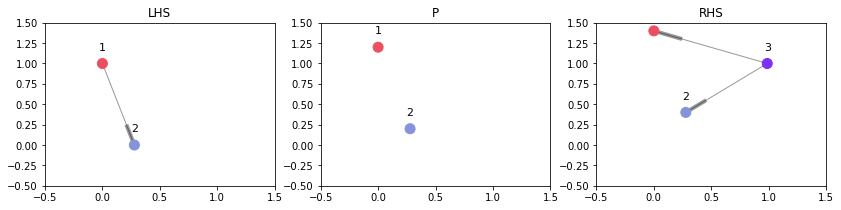

In [43]:
lhs = nx.DiGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(1, 2)])

p = nx.DiGraph()
p.add_nodes_from([1, 2])
p.add_edges_from([])

rhs = nx.DiGraph()
rhs.add_nodes_from([1, 2, 3])
rhs.add_edges_from([(3, 1), (3, 2)])

# By default if `p_lhs` and `p_rhs` are not provided
# to a rule, it tries to construct this homomorphisms
# automatically by matching the names. In this case we
# have defined lhs, p and rhs in such a way that that
# the names of the matching nodes correspond
rule = Rule(p, lhs, rhs)
plot_rule(rule)

Now, we would like to use the rule defined above in the following context: in the graph `G_prime` we want to find "protien" nodes connected to "binding" nodes and to delete the edge connecting them, after that we would like to add a new "region" node and connect it to the previous "protein" and "binding".

As our graphs do not exist by themselves, but are packed in the hierarchy, to rewrite the graph `G_prime` and preserve the structure of the hierarchy we need to type a rewriting rule by the node which immediately types `G_prime`, otherwise after rewriting `G_prime` will be not necessarily typed by `G` anymore.

It is also possible to apply any valid rewriting rule on any graph in the hierarchy without specifying a typing of the rule. However, in that case, any typing edge going out of the graph will be removed as there will be no guarantee that this typing remains a valid homomorphism.

In [44]:
lhs_typing = {
    "G": {
        1: "protein",
        2: "binding"
    }
}
rhs_typing = {
    "G": {
        1: "protein",
        2: "binding",
        3: "region"
    }
}

`regraph.library.Hierarchy` provides the method `find_matching` to find matchings of a pattern in a given graph in the hierarchy. The typing of $LHS$ should be provided to the `find_matching` method.

Instances found without pattern typing:
{1: 'SH2', 2: 'BND_1'}


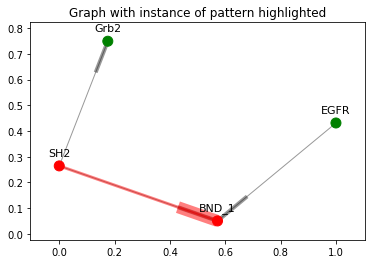

{1: 'SH2', 2: 'Grb2'}


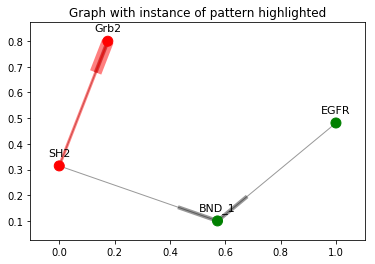

{1: 'EGFR', 2: 'BND_1'}


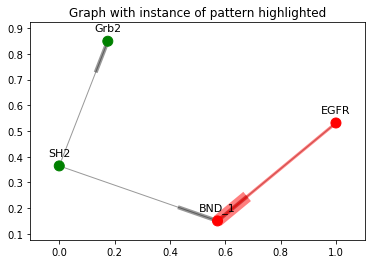



Instances found with pattern typing:
{1: 'EGFR', 2: 'BND_1'}


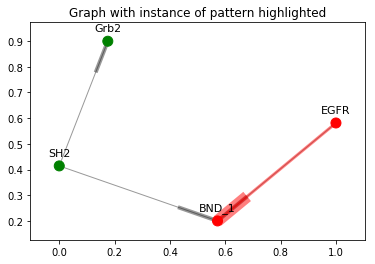

In [45]:
# Find matching of lhs without lhs_typing
instances_untyped = simple_hierarchy.find_matching("G_prime", lhs)
print("Instances found without pattern typing:")
for instance in instances_untyped:
    print(instance)
    plot_instance(simple_hierarchy.node["G_prime"].graph, lhs, instance, pos=pos)

# Find matching of lhs with lhs_typing
instances = simple_hierarchy.find_matching("G_prime", lhs, lhs_typing)
print("\n\nInstances found with pattern typing:")
for instance in instances:
    print(instance)
    plot_instance(simple_hierarchy.node["G_prime"].graph, lhs, instance, pos=pos)

Now, rewriting can be performed using `regraph.library.hierarchy.Hierarchy.rewrite` method. It takes as an input id of the graph to rewrite, an instance of the LHS of a rule, a rule, and an typing of $LHS$ and $RHS$ (in case the graph to be rewritten is not typed by any other graph in the hierarchy, the $LHS$ and $RHS$ typings are not required).

In [46]:
try:
    simple_hierarchy.rewrite("G_prime", instances_untyped[1], rule, lhs_typing, rhs_typing)
except:
    print("If typing of the instance of LHS does not coincide with typing of LHS, rewriting procedure returns and error!")

If typing of the instance of LHS does not coincide with typing of LHS, rewriting procedure returns and error!


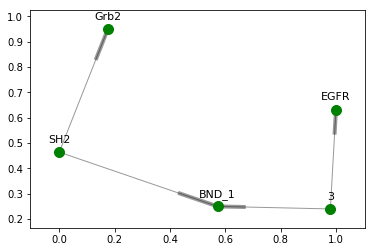

{3: array([ 0.97985325,  0.28995395]),
 'SH2': array([ 0.        ,  0.51407747]),
 'EGFR': array([ 1.        ,  0.68103955]),
 'BND_1': array([ 0.57199063,  0.3       ]),
 'Grb2': array([ 0.17548441,  0.9990971 ])}

In [47]:
simple_hierarchy.rewrite("G_prime", instances[0], rule, lhs_typing, rhs_typing)
plot_graph(simple_hierarchy.node["G_prime"].graph, parent_pos=pos)

It is possible to remove a graph from the hierarchy using the `regraph.library.hierarchy.Hierarchy.remove_graph` method. It takes as an input the id of a graph to remove, and if the argument `reconnect` is set to `True`, it 

In [48]:
simple_hierarchy.remove_graph("G", reconnect=True)
print(simple_hierarchy)
print("New node types in 'G_prime':")
for node in simple_hierarchy.node["G_prime"].graph.nodes():
    print(node, ": ", simple_hierarchy.node_type("G_prime", node))


Graphs (directed == True): 

Nodes:
Graph: G_prime {'name': 'EGFR and Grb2 binding'}
Graph: T {'name': 'Agent interation'}

Typing homomorphisms: 
G_prime -> T: ignore_attrs == False

attributes : 
{}

New node types in 'G_prime':
3 :  ['agent']
SH2 :  ['agent']
EGFR :  ['agent']
BND_1 :  ['action']
Grb2 :  ['agent']


### 2. Example: advanced hierarchy

The following example illustrates more sophisticaled hierarchy example.

In [49]:
hierarchy = Hierarchy()

colors = nx.DiGraph()
colors.add_nodes_from([
        "green", "red", "blue"
    ])
colors.add_edges_from([
        ("red", "green"),
        ("red", "red"),
        ("green", "green"),
        ("blue", "red")
    ])
hierarchy.add_graph("colors", colors, {"id": "https://some_url"})

shapes = nx.DiGraph()
shapes.add_nodes_from(["circle", "square"])
shapes.add_edges_from([
        ("circle", "square"),
        ("square", "circle"),
        ("circle", "circle")
    ])
hierarchy.add_graph("shapes", shapes)

quality = nx.DiGraph()
quality.add_nodes_from(["good", "bad"])
quality.add_edges_from([
        ("bad", "bad"),
        ("bad", "good"),
        ("good", "good")
    ])
hierarchy.add_graph("quality", quality)

g1 = nx.DiGraph()
g1.add_nodes_from([
        "red_circle",
        "red_square",
        "green_circle",
        "green_square"
    ])
g1.add_edges_from([
        ("red_circle", "green_circle"),
        ("red_circle", "red_square"),
        ("red_circle", "red_circle"),
        ("red_square", "red_circle"),
        ("green_circle", "green_square"),
        ("green_square", "green_circle")
    ])
g1_colors = {
    "red_circle": "red",
    "red_square": "red",
    "green_circle": "green",
    "green_square": "green"
}
g1_shapes = {
    "red_circle": "circle",
    "red_square": "square",
    "green_circle": "circle",
    "green_square": "square"
}

hierarchy.add_graph("g1", g1)
hierarchy.add_typing("g1", "colors", g1_colors)
hierarchy.add_typing("g1", "shapes", g1_shapes)

g2 = nx.DiGraph()
g2.add_nodes_from([
        "good_circle",
        "good_square",
        "bad_circle",
        "bad_square"
    ])
g2.add_edges_from([
        ("good_circle", "good_square"),
        ("good_square", "good_circle"),
        ("bad_circle", "good_circle"),
        ("bad_square", "bad_circle"),
        ("bad_circle", "good_square"),
        ("bad_circle", "bad_circle")
    ])
g2_shapes = {
    "good_circle": "circle",
    "good_square": "square",
    "bad_circle": "circle",
    "bad_square": "square"
}
g2_quality = {
    "good_circle": "good",
    "good_square": "good",
    "bad_circle": "bad",
    "bad_square": "bad"
}

hierarchy.add_graph("g2", g2)
hierarchy.add_typing("g2", "shapes", g2_shapes)
hierarchy.add_typing("g2", "quality", g2_quality)

g3 = nx.DiGraph()
g3.add_nodes_from([
        "good_red_circle",
        "bad_red_circle",
        "good_green_square",
        "bad_green_circle",
        "good_red_square"
    ])
g3.add_edges_from([
        ("bad_red_circle", "good_red_circle"),
        ("bad_red_circle", "good_red_square"),
        ("bad_red_circle", "bad_green_circle"),
        ("bad_green_circle", "good_green_square"),
        ("good_red_square", "good_red_circle"),
        ("good_red_circle", "good_red_square")
    ])

g3_g1 = {
    "good_red_circle": "red_circle",
    "bad_red_circle": "red_circle",
    "good_green_square": "green_square",
    "bad_green_circle": "green_circle",
    "good_red_square": "red_square"
}

g3_g2 = {
    "good_red_circle": "good_circle",
    "bad_red_circle": "bad_circle",
    "good_green_square": "good_square",
    "bad_green_circle": "bad_circle",
    "good_red_square": "good_square"
}

hierarchy.add_graph("g3", g3)
hierarchy.add_typing("g3", "g1", g3_g1)
hierarchy.add_typing("g3", "g2", g3_g2)

In [50]:
hierarchy.node_type("g3", "good_green_square")

['good_square', 'green_square']

In [51]:
lhs = nx.DiGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(1, 2)])

p = nx.DiGraph()
p.add_nodes_from([1, 11, 2])
p.add_edges_from([(1, 2)])

rhs = copy.deepcopy(p)

p_lhs = {1: 1, 11: 1, 2: 2}
p_rhs = {1: 1, 11: 11, 2: 2}

r1 = Rule(p, lhs, rhs, p_lhs, p_rhs)
hierarchy.add_rule("r1", r1, {"desc": "Rule 1: typed by two graphs"})

lhs_typing1 = {1: "red_circle", 2: "red_square"}
rhs_typing1 = {1: "red_circle", 11: "red_circle", 2: "red_square"}

lhs_typing2 = {1: "good_circle", 2: "good_square"}
rhs_typing2 = {1: "good_circle", 11: "good_circle", 2: "good_square"}

hierarchy.add_rule_typing("r1", "g1", lhs_typing1, rhs_typing1)
hierarchy.add_rule_typing("r1", "g2", lhs_typing2, rhs_typing2)

In [52]:
print(hierarchy)


Graphs (directed == True): 

Nodes:
Graph: shapes {}
Graph: colors {'id': 'https://some_url'}
Rule: r1 {'desc': 'Rule 1: typed by two graphs'}
Graph: g3 {}
Graph: quality {}
Graph: g2 {}
Graph: g1 {}

Typing homomorphisms: 
r1 -> g2: ignore_attrs == False
r1 -> g1: ignore_attrs == False
g3 -> g2: ignore_attrs == False
g3 -> g1: ignore_attrs == False
g2 -> shapes: ignore_attrs == False
g2 -> quality: ignore_attrs == False
g1 -> shapes: ignore_attrs == False
g1 -> colors: ignore_attrs == False

attributes : 
{}



In [53]:
lhs = nx.DiGraph()
lhs.add_nodes_from(["a", "b"])
lhs.add_edges_from([
        ("a", "b"),
        ("b", "a")
    ])
p = nx.DiGraph()
# p.add_nodes_from(["a", "b"])
p.add_nodes_from(["a", "a1", "b"])
p.add_edges_from([
        ("a", "b"),
        ("a1", "b")
    ])
rhs = copy.deepcopy(p)
rule = Rule(
    p, lhs, rhs,
#     {"a": "a", "b": "b"},
#     {"a": "a", "b": "b"},

    {"a": "a", "a1": "a", "b": "b"},
    {"a": "a", "a1": "a1", "b": "b"},
)

Instances:
{'b': 'square', 'a': 'circle'}


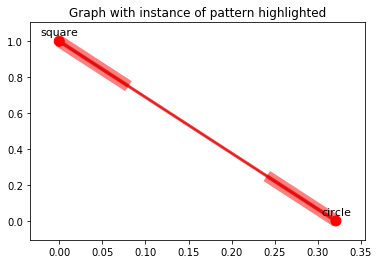

{'b': 'circle', 'a': 'square'}


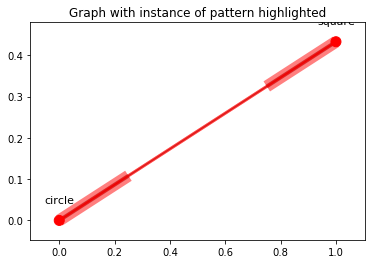

In [54]:
instances = hierarchy.find_matching("shapes", lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(hierarchy.node["shapes"].graph, rule.lhs, instance)

In [55]:
hierarchy.rewrite("shapes", {"a": "circle", "b": "square"}, rule)

UnboundLocalError: local variable 'new_lhs_typing' referenced before assignment

In [ ]:
print_graph(hierarchy.node["shapes"].graph)
print_graph(hierarchy.node["g1"].graph)
print_graph(hierarchy.node["g2"].graph)
print_graph(hierarchy.node["g3"].graph)
print_graph(hierarchy.node["r1"].rule.lhs)
print_graph(hierarchy.node["r1"].rule.p)
print_graph(hierarchy.node["r1"].rule.rhs)